# S1 Coursework

Yuanzhen Zhao (yz929)

In [ ]:
import numpy as np
from scipy.integrate import quad, dblquad
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL, ExtendedBinnedNLL
from dists import *
import timeit

from scipy.interpolate import interp1d
from scipy.optimize import brute

In [3]:
# Parameters
mu, sigma, beta, m, f, lmda, mu_b, sigma_b = 3, 0.3, 1, 1.4, 0.6, 0.3, 0, 2.5

## Question b

In [ ]:
# Check if normalisation is satisfied
print(f"The CDF of g_s over the interval [0, 5] evaluates to {quad(g_s, 0, 5, args=(beta, m, mu, sigma))[0]}")
print(f"The CDF of h_s over the interval [0,10] evaluates to {quad(h_s, 0, 10, args=(lmda,))[0]}")
print(f"The CDF of g_b over the interval [0, 5] evaluates to {quad(g_b, 0, 5)[0]}")
print(f"The CDF of h_b over the interval [0, 10] evaluates to {quad(h_b, 0, 10, args=(mu_b, sigma_b))[0]}")
print(f"The CDF of s_xy over the interval [0, 5] & [0, 10] evaluates to {dblquad(s_xy, 0, 5, 0, 10, args=(beta, m, mu, sigma, lmda))[0]}")
print(f"The CDF of b_xy over the interval [0, 5] & [0, 10] evaluates to {dblquad(b_xy, 0, 5, 0, 10, args=(mu_b, sigma_b))[0]}")
print(f"The CDF of f_xy over the interval [0, 5] & [0, 10] evaluates to {dblquad(f_xy, 0, 5, 0, 10, args=(mu, sigma, beta, m, f, lmda, mu_b, sigma_b))[0]}")

The CDF of g_s over the interval [0, 5] evaluates to 1.0000000376260723
The CDF of h_s over the interval [0,10] evaluates to 1.0
The CDF of g_b over the interval [0, 5] evaluates to 1.0000000000000002
The CDF of h_b over the interval [0, 10] evaluates to 1.0
The CDF of s_xy over the interval [0, 5] x [0, 10] evaluates to 1.0000000376260723
The CDF of b_xy over the interval [0, 5] x [0, 10] evaluates to 1.0000000000000002
The CDF of f_xy over the interval [0, 5] x [0, 10] evaluates to 1.0000000225756434


## Question c

In [6]:
x = np.linspace(0, 5, 200)
y = np.linspace(0, 10, 200)

P_x = f * g_s(x, beta, m, mu, sigma) + (1-f) * g_b(x)
P_y = f * h_s(y, lmda) + (1-f) * h_b(y, mu_b, sigma_b)

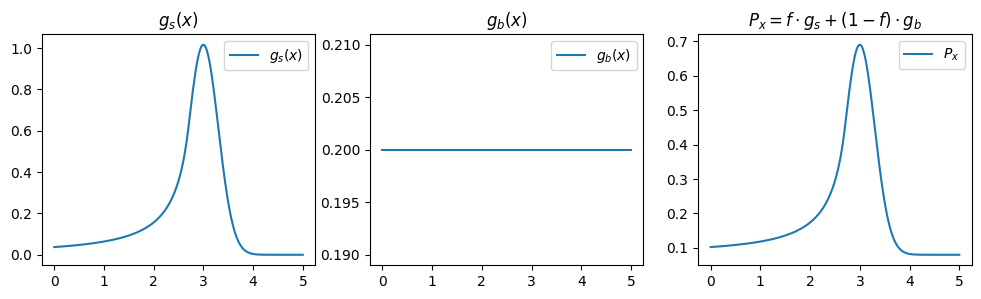

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].plot(x, g_s(x, beta, m, mu, sigma), label='$g_s(x)$')
ax[0].set_title('$g_s(x)$')
ax[0].legend()

ax[1].plot(x, g_b(x), label='$g_b(x)$')
ax[1].set_title('$g_b(x)$')
ax[1].legend()

ax[2].plot(x, P_x, label='$P_x$')
ax[2].set_title('$P_x = f \\cdot g_s + (1-f) \\cdot g_b$')
ax[2].legend()

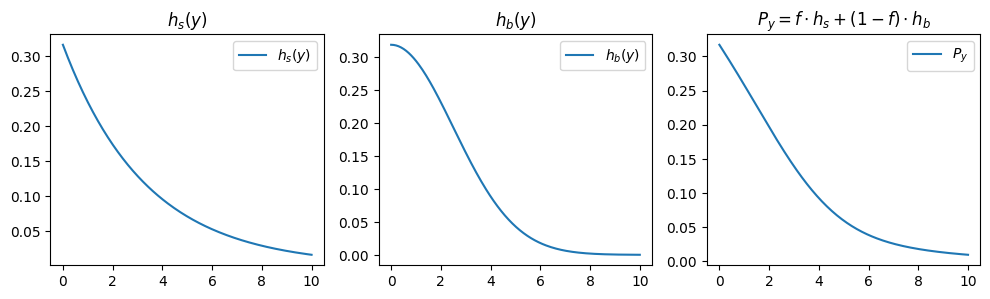

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].plot(y, h_s(y, lmda), label='$h_s(y)$')
ax[0].set_title('$h_s(y)$')
ax[0].legend()


ax[1].plot(y, h_b(y, mu_b, sigma_b), label='$h_b(y)$')
ax[1].set_title('$h_b(y)$')
ax[1].legend()

ax[2].plot(y, P_y, label='$P_y$')
ax[2].set_title('$P_y = f \\cdot h_s + (1-f) \\cdot h_b$')
ax[2].legend()

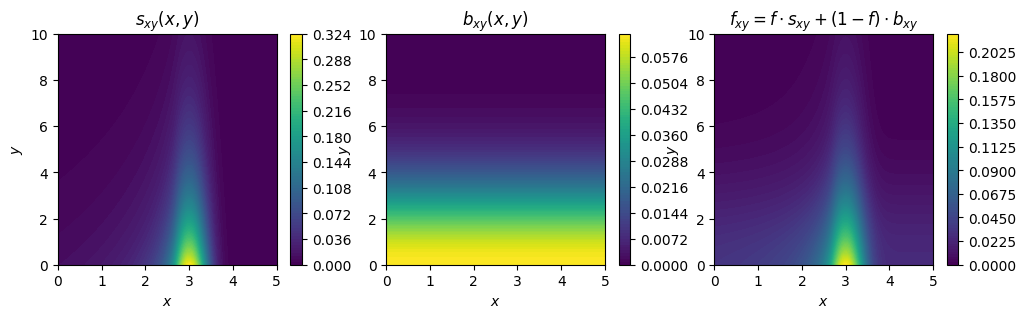

In [9]:
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

sxy = ax[0].contourf(X, Y, s_xy(Y, X, beta, m, mu, sigma, lmda), levels=100)
ax[0].set_title('$s_{xy}(x,y)$')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
fig.colorbar(sxy, ax=ax[0])

bxy = ax[1].contourf(X, Y, b_xy(Y, X, mu_b, sigma_b), levels=100)
ax[1].set_title('$b_{xy}(x,y)$')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$y$')
fig.colorbar(bxy, ax=ax[1])

fxy = ax[2].contourf(X, Y, f_xy(Y, X, mu, sigma, beta, m, f, lmda, mu_b, sigma_b), levels=100)
ax[2].set_title('$f_{xy} = f \\cdot s_{xy} + (1-f) \\cdot b_{xy}$')
ax[2].set_xlabel('$x$')
ax[2].set_ylabel('$y$')
fig.colorbar(fxy, ax=ax[2])

plt.show()


## Question d

In [88]:
def unbinned_fit(samples, density, num_samples=100000):
    """Fit the model to the data using the unbinned likelihood method."""
    N = np.random.poisson(num_samples)
    nll = ExtendedUnbinnedNLL((samples[:, 0], samples[:, 1]), density)
    mi = Minuit(nll, mu=3, sigma=0.3, beta=1, m=1.4, f=0.6, lmda=0.3, mu_b=0, sigma_b=2.5, N=N)
    mi.migrad()
    mi.hesse()
    return mi

In [78]:
def density(xy, mu=3, sigma=0.3, beta=1, m=1.4, f=0.6, lmda=0.3, mu_b=0, sigma_b=2.5, N=100000):
    # Unpack the data
    x, y = xy
    return N, N*f_xy(y, x, mu, sigma, beta, m, f, lmda, mu_b, sigma_b)

Generating samples using inverse transform sampling

In [81]:
def inverse_transform_sampling(N, mu=3, sigma=0.3, beta=1, m=1.4, f=0.6, lmda=0.3, mu_b=0, sigma_b = 2.5):
    """Generate N samples from the joint distribution f_xy(x, y) using the inverse transform sampling method."""
    g_s_model = crystalball(beta=beta, m=m, loc=mu, scale=sigma)
    h_s_model = truncexpon(b=10*lmda, loc=0, scale=1/lmda)
    g_b_model = uniform(loc=0, scale=5)
    h_b_model = truncnorm(a=(0-mu_b)/sigma_b, b=(10-mu_b)/sigma_b, loc=mu_b, scale=sigma_b)
    
    Ns = int(f * N)
    Nb = int((1-f) * N)
    
    g_s_uniform_samples = np.random.uniform(g_s_model.cdf(0), g_s_model.cdf(5), size=Ns)
    Xs = g_s_model.ppf(g_s_uniform_samples) # Make sure Xs are sampled in the range [0,5]
    
    g_b_uniform_samples = np.random.uniform(g_b_model.cdf(0), g_b_model.cdf(5), size=Nb)
    Xb = g_b_model.ppf(g_b_uniform_samples) # Make sure Xb are sampled in the range [0,5]
    
    Ys = h_s_model.rvs(size=Ns)
    Yb = h_b_model.rvs(size=Nb)

    sevs = np.column_stack((Xs, Ys))
    bevs = np.column_stack((Xb, Yb))
    
    xyvalues = np.concatenate((sevs, bevs))
    
    return xyvalues

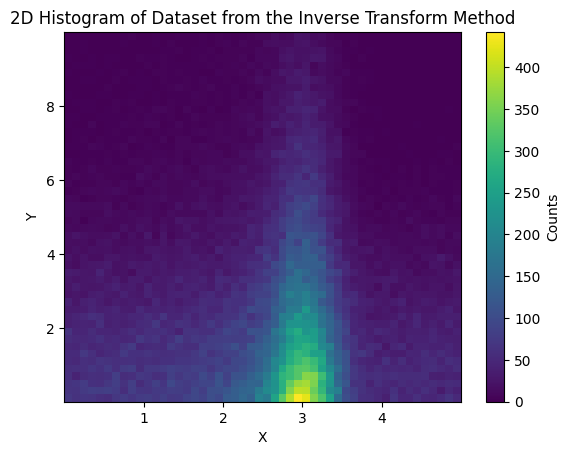

In [82]:
inverse_transform_sampling_dataset = inverse_transform_sampling(100000)

plt.hist2d(inverse_transform_sampling_dataset[:, 0], inverse_transform_sampling_dataset[:, 1], bins=[50, 50], cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Histogram of Dataset from the Inverse Transform Method')
plt.show()

In [120]:
mi = unbinned_fit(inverse_transform_sampling_dataset, density)
display(mi)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.461e+06                 │              Nfcn = 288              │
│ EDM = 0.000105 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu      │  2.9992   │  0.0027   │            │            │         │         │       │
│ 1 │ sigma   │  0.2984   │  0.0025   │            │            │         │         │       │
│ 2 │ beta    │   0.986   │   0.022   │            │            │         │         │       │
│ 3 │ m       │   1.44    │   0.06    │            │            │         │         │       │
│ 4 │ f       │   0.599   │   0.004   │            │            │         │         │       │
│ 5 │ lmda    │  0.2985   │  0.0021   │            │            │         │         │       │
│ 6 │ mu_b    │   -0.05   │   0.08    │            │            │         │         │       │
│ 7 │ sigma_b │   2.52    │   0.04    │            │            │         │         │       │
│ 8 │ N       │ 100.00e3  │  0.32e3   │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│         │        mu     sigma      beta         m         f      lmda      mu_b   sigma_b         N │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│      mu │  7.12e-06     -4e-6    -33e-6     62e-6     -0e-6     -0e-6     -3e-6      2e-6      0e-6 │
│   sigma │     -4e-6  6.07e-06     27e-6    -56e-6      2e-6      0e-6     16e-6    -10e-6     -0e-6 │
│    beta │    -33e-6     27e-6    0.0005   -1.2e-3  0.007e-3      0e-6    0.1e-3        -0        -0 │
│       m │     62e-6    -56e-6   -1.2e-3   0.00417 -0.085e-3    -11e-6    -0.001    0.0004     0.000 │
│       f │     -0e-6      2e-6  0.007e-3 -0.085e-3  1.26e-05      2e-6  0.051e-3 -0.030e-3         0 │
│    lmda │     -0e-6      0e-6      0e-6    -11e-6      2e-6  4.24e-06      9e-6      4e-6      0e-6 │
│    mu_b │     -3e-6     16e-6    0.1e-3    -0.001  0.051e-3      9e-6   0.00656   -0.0028     0.000 │
│ sigma_b │      2e-6    -10e-6        -0    0.0004 -0.030e-3      4e-6   -0.0028    0.0014   -0.0000 │
│       N │      0e-6     -0e-6        -0     0.000         0      0e-6     0.000   -0.0000     1e+05 │
└─────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [ ]:
# Store the estimates and errors of the parameters
inverse_transform_sampling_estimates = {
    'mu': {'value': mi.values['mu'], 'error': mi.errors['mu']},
    'sigma': {'value': mi.values['sigma'], 'error': mi.errors['sigma']},
    'beta': {'value': mi.values['beta'], 'error': mi.errors['beta']},
    'm': {'value': mi.values['m'], 'error': mi.errors['m']},
    'f': {'value': mi.values['f'], 'error': mi.errors['f']},
    'lmda': {'value': mi.values['lmda'], 'error': mi.errors['lmda']},
    'mu_b': {'value': mi.values['mu_b'], 'error': mi.errors['mu_b']},
    'sigma_b': {'value': mi.values['sigma_b'], 'error': mi.errors['sigma_b']}
}

Accept-Reject method

In [138]:
def find_max(func, xrange, yrange, **kwargs):
    """Find the maximum of a function with two arguments over a given range"""
    f = lambda xy: -func(xy[1], xy[0], **kwargs)
    X = brute(f, [xrange, yrange])
    fmax = -f(X)
    return fmax

In [ ]:
f_xy_max = find_max(f_xy, [0, 5], [0, 10], mu = 3, sigma = 0.3, beta = 1, m = 1.4, f = 0.6, lmda = 0.3, mu_b = 0, sigma_b = 2.5)

In [101]:
def accept_reject(size):
    """Generate samples from f_xy using the accept-reject method"""
    num_random = 2000000
    x_values = np.random.uniform(0, 5, num_random)
    y_values = np.random.uniform(0, 10, num_random)
    f_values = f_xy(y_values, x_values, mu=3, sigma=0.3, beta=1, m=1.4, f=0.6, lmda=0.3, mu_b=0, sigma_b = 2.5)
    u_values = np.random.uniform(0, f_xy_max, num_random)
    
    valid = u_values < f_values
    
    valid_sample = np.column_stack((x_values[valid], y_values[valid]))
    
    return valid_sample[:size]

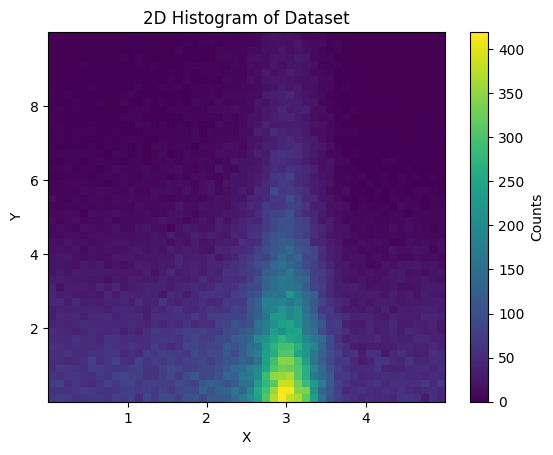

In [102]:
accept_reject_dataset = accept_reject(100000)
plt.hist2d(accept_reject_dataset[:, 0], accept_reject_dataset[:, 1], bins=[50, 50], cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Histogram of Dataset')
plt.show()

In [121]:
mi = unbinned_fit(accept_reject_dataset, density)
display(mi)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.46e+06                  │              Nfcn = 327              │
│ EDM = 0.000166 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu      │  2.9986   │  0.0026   │            │            │         │         │       │
│ 1 │ sigma   │  0.2985   │  0.0024   │            │            │         │         │       │
│ 2 │ beta    │   1.005   │   0.022   │            │            │         │         │       │
│ 3 │ m       │   1.35    │   0.06    │            │            │         │         │       │
│ 4 │ f       │  0.5987   │  0.0035   │            │            │         │         │       │
│ 5 │ lmda    │  0.2992   │  0.0021   │            │            │         │         │       │
│ 6 │ mu_b    │   0.12    │   0.07    │            │            │         │         │       │
│ 7 │ sigma_b │   2.449   │   0.035   │            │            │         │         │       │
│ 8 │ N       │ 100.00e3  │  0.32e3   │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│         │        mu     sigma      beta         m         f      lmda      mu_b   sigma_b         N │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│      mu │  6.56e-06     -3e-6    -28e-6     48e-6     -0e-6      0e-6     -2e-6      1e-6     -0e-6 │
│   sigma │     -3e-6   5.7e-06     23e-6    -44e-6      2e-6      0e-6     14e-6     -9e-6      0e-6 │
│    beta │    -28e-6     23e-6  0.000473   -1.1e-3  0.006e-3      0e-6    0.1e-3        -0         0 │
│       m │     48e-6    -44e-6   -1.1e-3   0.00337 -0.072e-3     -9e-6   -0.0005    0.0003   -0.0000 │
│       f │     -0e-6      2e-6  0.006e-3 -0.072e-3  1.25e-05      2e-6  0.047e-3 -0.029e-3         0 │
│    lmda │      0e-6      0e-6      0e-6     -9e-6      2e-6  4.23e-06      9e-6      4e-6     -0e-6 │
│    mu_b │     -2e-6     14e-6    0.1e-3   -0.0005  0.047e-3      9e-6   0.00537   -0.0024    -0.000 │
│ sigma_b │      1e-6     -9e-6        -0    0.0003 -0.029e-3      4e-6   -0.0024   0.00124    0.0000 │
│       N │     -0e-6      0e-6         0   -0.0000         0     -0e-6    -0.000    0.0000     1e+05 │
└─────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [104]:
# Store the estimates and errors of the parameters
accept_reject_estimates = {
    'mu': {'value': mi.values['mu'], 'error': mi.errors['mu']},
    'sigma': {'value': mi.values['sigma'], 'error': mi.errors['sigma']},
    'beta': {'value': mi.values['beta'], 'error': mi.errors['beta']},
    'm': {'value': mi.values['m'], 'error': mi.errors['m']},
    'f': {'value': mi.values['f'], 'error': mi.errors['f']},
    'lmda': {'value': mi.values['lmda'], 'error': mi.errors['lmda']},
    'mu_b': {'value': mi.values['mu_b'], 'error': mi.errors['mu_b']},
    'sigma_b': {'value': mi.values['sigma_b'], 'error': mi.errors['sigma_b']}
}

In [119]:
benchmark_time = %timeit -o -n 100 np.random.normal(size=100000)
inverse_transform_sampling_time = %timeit -o -n 100 inverse_transform_sampling(100000)
accept_reject_time = %timeit -o -n 100 accept_reject(100000)
fit_inverse_transform_sampling_time = %timeit -o -n 100 unbinned_fit(inverse_transform_sampling_dataset, density)
fit_accept_reject_time = %timeit -o -n 100 unbinned_fit(accept_reject_dataset, density)

1.35 ms ± 38.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.7 ms ± 401 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
636 ms ± 54 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


KeyboardInterrupt: 

In [ ]:
print(f"The benchmark time is {benchmark_time.average:.6f} seconds")
print(f"The inverse transform sampling time is {inverse_transform_sampling_time.average:.6f} seconds, which is about {inverse_transform_sampling_time.average/benchmark_time.average:.2f} times the benchmark time")
print(f"The accept-reject sampling time is {accept_reject_time.average:.6f} seconds, which is about {accept_reject_time.average/benchmark_time.average:.2f} times the benchmark time")
print(f"The fitting time for the inverse transform sampling dataset is {fit_inverse_transform_sampling_time.average:.6f} seconds, which is about {fit_inverse_transform_sampling_time.average/benchmark_time.average:.2f} times the benchmark time")
print(f"The fitting time for the accept-reject sampling dataset is {fit_accept_reject_time.average:.6f} seconds, which is about {fit_accept_reject_time.average/benchmark_time.average:.2f} times the benchmark time")

## Question e

Now run a simulation study using parametric bootstrapping (with an ensemble
of at least 250 samples) from the true probability distribution. You should trial
sample sizes of 500, 1000, 2500, 5000 and 10000, including a Poisson variation on
the sample size. Determine whether you see any bias on the 𝜆 parameter,
describing the decay constant of the signal in 𝑌, as a function of the sample size.
Also determine the expected uncertainty on 𝜆 as a function of the sample size.

现在进行一个模拟研究，使用参数自助法（从真实概率分布中生成至少250个样本的集合）。您应该尝试以下样本量：500、1000、2500、5000和10000，并包括样本量上的泊松变化。确定是否可以观察到𝜆参数（描述信号在𝑌中的衰减常数）的偏差随样本量的变化情况。同时，确定𝜆的预期不确定性如何随样本量的变化而变化

In [ ]:
sample_sizes = [50, 1000, 2500, 5000, 10000]


0.29907292607760827

In [ ]:
from resample import bootstrap
for sample_size in sample_sizes:
    bstrp = np.array( [ b for b in bootstrap.resample(samples, size=sample_size) ] )